In [1]:
import numpy as np
import scanpy as sc
import os
import torch
from pathlib import Path

os.environ['R_HOME'] = 'C:/Program Files/R/R-4.3.1'

### Change the data path to your dir_path here

In [2]:
from mucstpy.utils import read_10x_visium

adata = read_10x_visium(path='D:/st_projects/data/Mouse_Coronal_Brain_DAPI')
adata.var_names_make_unique()
adata

C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())
C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\anndata\_core\anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\anndata\_core\anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 2903 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'image_col', 'image_row'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

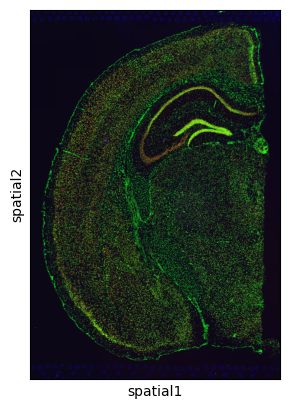

In [3]:
sc.pl.spatial(adata)

In [4]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
adata = adata[:, adata.var['total_counts'] > 100]
adata.raw = adata

sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=False, max_value=10)

In [5]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


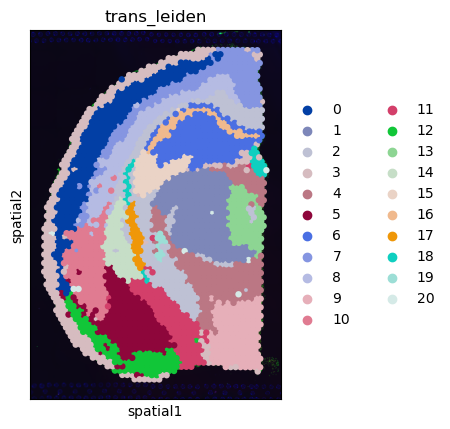

In [6]:
sc.tl.leiden(adata, key_added='trans_leiden')
sc.pl.spatial(adata, color=['trans_leiden'], size=2)

### We must note that, for different SRT dataset, the crop size is also different.

In [7]:
from mucstpy.image_feature import ImageFeature, image_crop

section = 'DAPI_Mouse'
save_path = 'results'
save_path_image_crop = Path(os.path.join(save_path, 'image_crop', f'{section}'))
save_path_image_crop.mkdir(parents=True, exist_ok=True)

adata = image_crop(adata, crop_size=29, save_path=save_path_image_crop, verbose=False)
adata = ImageFeature(adata, pca_components=200, verbose=True, seeds=2023).extract_image_features()
adata

Tiling Image: 100%|██████████ [ time left: 00:00 ]
Extract image feature: 100%|██████████ [ time left: 00:00 ]


The image feature is added to adata.obsm['Image_Feature']
The pca result of image features is added to adata.obsm['image_feat_pca']


AnnData object with n_obs × n_vars = 2903 × 12918
    obs: 'in_tissue', 'array_row', 'array_col', 'image_col', 'image_row', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'trans_leiden', 'slice_path'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'trans_leiden_colors'
    obsm: 'spatial', 'X_pca', 'X_umap', 'image_feature', 'aug_image_feature1', 'aug_image_feature2', 'image_feat_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [8]:
sc.pp.neighbors(adata, use_rep='image_feat_pca')
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added='graph_leiden', resolution=1.5)

C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


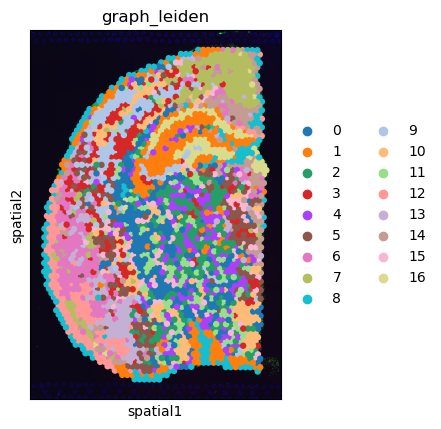

In [9]:
sc.pl.spatial(adata, color=['graph_leiden'], size=2)

In [10]:
from sklearn.metrics import pairwise_distances
from mucstpy.utils import construction_interaction

construction_interaction(adata, n_neighbor=6)
adj = adata.obsm['adj']

morphological_similarity = 1 - pairwise_distances(np.array(adata.obsm['image_feat_pca']), metric='cosine')
morphological_similarity[morphological_similarity < 0] = 0

adj_spatial_mor = adj * morphological_similarity
adata.obsm['mor_adj'] = adj_spatial_mor

In [11]:
from mucstpy.utils import data_augmentation

data_augmentation(adata, aug_para=0.2)

918 [968 969 970 971 973]
1409 [ 971  972  973  965 2902]
2605 [ 971  972  973  964 2902]


In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
device

device(type='cuda')

In [13]:
from mucstpy import MuCST
from mucstpy.utils import get_feature, add_contrastive_label

add_contrastive_label(adata)
get_feature(adata)

gene_dims=[adata.shape[1], 64]
img_dims=[adata.obsm['image_feature'].shape[1], 64]
project_dims=[64, 32, 16]

MuCST.train_model(adata, gene_dims=gene_dims, img_dims=img_dims, proj_dims=project_dims, lamb1=1, lamb3=0.2, device=device)

Begin to train MuCST...


# Epoch 1499, loss: 0.974, g2g_loss: 0.507, gene_recon: 0.921, image_recon: 0.003:  97%|█████████▋| 1499/1550 [00:22<00:00, 66.79it/s]

# Epoch 1500, loss: 14.753, g2g_loss: 0.507, gene_recon: 0.921, image_recon: 0.003
Init finished, start contrastive learning part


# Epoch 1549, loss: 11.366, g2i_loss: 8.552, g2g_loss: 0.603, i2i_loss: 8.659, gene_recon: 0.932, image_recon: 0.004: 100%|██████████| 1550/1550 [01:00<00:00, 25.45it/s] 


Optimization of MuCST finished


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


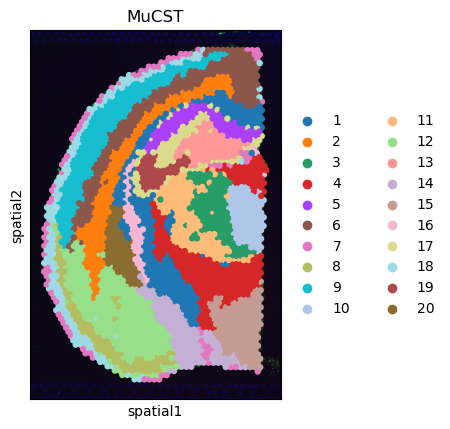

In [14]:
from mucstpy.utils import mclust_R
import os
os.environ['R_HOME'] = 'C:/Program Files/R/R-4.3.1'

tool = 'mclust'

mclust_R(adata, used_obsm='fusion_pca', num_cluster=20)
sc.pl.spatial(adata, color=['mclust'], title=['MuCST'], size=2)